# Karaoke Party At Home!!
## PIC 16B Final Project 
### By Isabella Woulfe, Anika Misra, and Athena Mo

Our project aims to address the problem of not finding clean karaoke background tracks
with simply chords for songs by Top Ten Artists. Oftentimes, people want clean instrumental versions of songs that do not
have additional background vocals, additional instruments, or have required ads that you need
to watch before getting access to the karaoke backtrack. Oftentimes, musicians want to layer on
their own instruments and their own vocals, and quickly need the chord sounds for the song—nothing else.

In general our project was divided into three main segments: gathering data using webscraping, creating music, and displaying on a a web app. Through this we successfully completed the following components:
- Web scraping 
- Working with large and messy data 
- Building a dynamic website 
- Using packages not introduced in PIC 16A or PIC 16B

Through the three following project sections, we were able to excute and interesting and interactive project. 







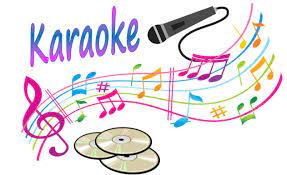

## Part 1: Our Webscraper

Before we could start creating actual music, we needed to start with gathering our data through webscraping. After lots of research, we decided the best website to gather our data from would be Chordify.net. Chordify is a platform that allows musicians of all levels to learn how to play popular songs on either the guitar, ukulele, piano, or mandolin. From this website, we collected chords and bar lengths in the form of dictionaries, the url for each individual song, and the song titles in the form of a string. 

To implement our scraper, we used both Scrapy and Selenium. We all had a thorough understanding of scrapy from Homework 2 but decided to pair it with Selenium to help us better navigate the websites we were scraping. 

After creating our scraper, we decided to organize our data into seperate csv files for each artist. By doing so, it was not only easier to work with our data but also makes for a mor eorganized experience for our website users. 

Here is our code for our chord_spider.py. 

In [ ]:
import scrapy 
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.chrome.options import Options as ChromeOptions
from scrapy.selector import Selector
from scrapy.http import Request
import time 

# HERE IS WHAT TO PUT IN THE TERMINAL: 

# top 10 artists US 
# scrapy crawl chord_scraper -o results.csv -a artistname=dua-lipa
# scrapy crawl chord_scraper -o taylorswift.csv -a artistname=taylor-swift
# scrapy crawl chord_scraper -o badbunny.csv -a artistname=bad-bunny
# scrapy crawl chord_scraper -o theweeknd.csv -a artistname=the-weeknd
# scrapy crawl chord_scraper -o drake.csv -a artistname=drake
# scrapy crawl chord_scraper -o travisscott.csv -a artistname=travi-scott
# scrapy crawl chord_scraper -o beyonce.csv -a artistname=beyonce
# scrapy crawl chord_scraper -o michaeljackson.csv -a artistname=michael-jackson
# scrapy crawl chord_scraper -o ladygaga.csv -a artistname=lady-gaga
# scrapy crawl chord_scraper -o arianagrande.csv -a artistname=ariana-grande


class chord_scraper(scrapy.Spider): 
    name = 'chord_scraper'
    
    def __init__(self, artistname, *args, **kwargs): 
        super().__init__(*args, **kwargs)  
        # format artist name properly 
        artistname_formatted = ("-".join(artistname.split())).lower()
        
        # form url of artist page 
        artist_page_url = "https://chordify.net/chords/"+artistname_formatted+"-songs"
        # need to add an error catcher for if this artist page doesn't exist 
        self.start_urls = [artist_page_url]
        
        # firefox option: 
        #options = Options()
        #options.headless = True
        #firefox_profile = webdriver.FirefoxProfile()
        #firefox_profile.set_preference("browser.privatebrowsing.autostart", True)
        #self.driver = webdriver.Firefox(options=options)
        
        # chrome option 
        options = ChromeOptions()
        options.add_argument("--incognito")
        options.add_argument("--headless")

        self.driver = webdriver.Chrome(options=options)
    def parse(self, response):
        """
        Parses artist's page and returns url for each song. 
        Calls the parse_song_url function for each song page url. 
        """
        
        self.driver.get(response.url) 
        # wait for page to load 
        time.sleep(5)
        html = self.driver.page_source
        sel = Selector(text=html) 
        # select the main div containing all the songs
        main_div = sel.css('div.s1qyqb8i.g1aau9lx')
        
        for link in sel.css('div.s1qyqb8i.g1aau9lx a::attr(href)'):
        # get the url for the songs 
            song_url = link.get()
            base_url = "https://chordify.net" + song_url # hard-coded url is okay 
            # call next scraper for the songs 
            yield scrapy.Request(url = base_url, callback = self.parse_song_url)
    def parse_song_url(self, response): 
        """
        Parses song page and yields dictionary of chords for each song. 
        Input is the song page from the first parse page. 
        Dictionary output contains bar number as key, and a tuple of (chord, bar length) for each value. 
        """
        self.driver.get(response.url)
        # wait for page to load 
        time.sleep(5)
        html = self.driver.page_source
        sel = Selector(text=html)
        
        song_url = response.url
        start = song_url.rfind("/")
        end = len(song_url) - 7 
        song_title = song_url[start+1:end]
        song_title = (song_title.replace('-', ' ')).title()

        # use sel just like the response, just as we did with scrapy 
        div = sel.css('div.s4xyh0t > div.chords')
        barlength = div.css('::attr(class)').re_first('barlength-(\d+)')
        tags_with_i_value = div.css('[data-i]')
        table = [{'i-value': tag.css('::attr(data-i)').get(), 'data-handle': tag.css('::attr(data-handle)').get(), 'barlength': barlength} for tag in tags_with_i_value]
        # create dicionary output for each song 
        dict_of_chords = dict()
        for row in table: 
            i_value = row['i-value']
            chord = row['data-handle']
            barlength = row['barlength']
            # make a dictionary that contains bar number in key and chord and bar length (tuple) in value. 
            dict_of_chords[i_value] = (chord, barlength) 
        # yield the result as a dictionary
        yield {
            'song_name': song_title,
            'song_url': song_url,
            'song_chords': dict_of_chords
            }

    def closed(self, reason):
        """
        Closes the web driver. 
        """
        self.driver.quit()
        

After scraping our data from Chordify, by running the commented lines in our terminal, we received several resulting csv files. Let's take a look for at the file for Taylor Swift using pandas!

In [1]:
import pandas as pd
filename = "taylor-swift.csv"
df = pd.read_csv(filename)
df

,song_name,song_url,song_chords
0,Look What You Made Me Do 2,https://chordify.net/chords/taylor-swift-songs...,"{'0': ('N', '4'), '1': ('N', '4'), '2': ('N', ..."
1,Opening,https://chordify.net/chords/taylor-swift-songs...,"{'0': ('N', '4'), '1': ('N', '4'), '2': ('N', ..."
2,I Knew You Were Trouble 2,https://chordify.net/chords/taylor-swift-songs...,"{'0': ('N', '4'), '1': ('N', '4'), '2': ('N', ..."
3,Willow,https://chordify.net/chords/taylor-swift-songs...,"{'0': ('N', '4'), '1': ('E:min', '4'), '2': ('..."
4,August,https://chordify.net/chords/taylor-swift-songs...,"{'0': ('N', '4'), '1': ('N', '4'), '2': ('N', ..."
5,Back To December,https://chordify.net/chords/taylor-swift-songs...,"{'0': ('N', '4'), '1': ('N', '4'), '2': ('N', ..."
6,Style 3,https://chordify.net/chords/taylor-swift-songs...,"{'0': ('N', '4'), '1': ('N', '4'), '2': ('N', ..."
7,Everything Has Changed 2,https://chordify.net/chords/taylor-swift-songs...,"{'0': ('F#:maj', '4'), '1': ('F#:maj', '4'), '..."
8,Message In A Bottle Taylor S Version From The ...,https://chordify.net/chords/taylor-swift-songs...,"{'0': ('N', '4'), '1': ('G:maj', '4'), '2': ('..."
9,Anti Hero,https://chordify.net/chords/taylor-swift-songs...,"{'0': ('N', '4'), '1': ('N', '4'), '2': ('N', ..."


Now that we have successfully created our csv files, we can extract this data and use it in our next step to create some great tracks!

## Part 2: Music Generating File

For our project, we really wanted to look outside the scope of this course and try something completely new. Our goal with this project was to create actual music in the form of audio files that users could listen and sing along to. In order to achieve this goal, we had to research other Python packages. Thanks to several different websites, most notably an article on Medium.com by Steve Hiehn. 

The first package we used was **MIDIUtil**. This specific allowed us to create an audiofile using the notes and chords we obtained in our data set. The next two packages we used helped our system understand different music terms and what they mean. These two functions are called **mingus.core** and **pychord**. These packages allow us to use note and chord names in our code and they will relate to the correct idea in music. We also continued to use Pandas to extract different elements within our dataset. 

After downloading the necessary packages and ensuring we had the necessary data, we needed clean and reorganize our chord data. At this time, all of our chords were organized in different dictionaries. Using Pandas, we were able to pull out the chord names (in the form of strings) and organize them into a list. We then organized our elements of the list so they were in a form that Mingus.core and Pychord would recognize. Once we had all of the chords, we used our packages to create a list of the corresponding notes. 

Finally, we developed a function, thanks to Steve Hiehn's guidance, that creates an audio file out of the list of notes with a given tempo and volume. Please see the code below. 

In [ ]:
from midiutil import MIDIFile
from mingus.core import chords
import ast
import pandas as pd
from pychord import Chord


OCTAVES = list(range(11))

errors = {
    'error!!!'
}

def read_csvpath_from_file():
    with open('config.txt', 'r') as file:
        for line in file:
            if line.startswith('csv_path'):
                variable_value = line.split('=')[1].strip().strip('"')
                return variable_value
    return None

def read_index_from_file():
    with open('config.txt', 'r') as file:
        for line in file:
            if line.startswith('user_song'):
                variable_value = line.split('=')[1].strip().strip('"')
                return variable_value
    return None

csvpath = read_csvpath_from_file()
df = pd.read_csv(csvpath)
df.head()
df = pd.read_csv(csvpath)
index = read_index_from_file()
index = int(index)
song_name = df.iloc[index, 0]
chords_string = df.loc[df['song_name'] == song_name, 'song_chords'].values[0]

NOTES = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B']
OCTAVES = list(range(11))
NOTES_IN_OCTAVE = len(NOTES)

chords = ast.literal_eval(chords_string)
extracted_strings = []
# iterate through dictionary values 
for key, value in chords.items():
    extracted_strings.append(value[0])  # Append the first element of the tuple
# get barlength 
first_item = list(chords.keys())[0]
bar_length = chords[first_item][1]

# clean up webscraper code 
original_list = extracted_strings
# Remove semicolons from each string
cleaned_list = [s.replace(':', '') for s in original_list]

def chords_to_notes(chord_list):
    """
    Given a list of chord names, returns a list of corresponding notes.
    """
    notes_list = []
    for chord_name in chord_list:
        if chord_name == 'N':
            # Handle the special case of a rest
            notes_list.append('')
        else:
            try:
                chord = Chord(chord_name)
                notes = chord.components()
                # Filter out numeric indices (only keep strings)
                notes = [note for note in notes if isinstance(note, str)]
                notes_list.extend(notes)
            except ValueError:
                # Handle invalid chord names gracefully
                pass
    return notes_list

chord_names = cleaned_list
resulting_notes = chords_to_notes(chord_names)


def swap_accidentals(note):
    if note == 'Db':
        return 'C#'
    if note == 'D#':
        return 'Eb'
    if note == 'E#':
        return 'F'
    if note == 'Gb':
        return 'F#'
    if note == 'G#':
        return 'Ab'
    if note == 'A#':
        return 'Bb'
    if note == 'B#':
        return 'C'

    return note


def note_to_number(note: str, octave: int) -> int:
    note = swap_accidentals(note)
    assert note in NOTES, errors['notes']
    assert octave in OCTAVES, errors['notes']

    note = NOTES.index(note)
    note += (NOTES_IN_OCTAVE * octave)

    assert 0 <= note <= 127, errors['notes']

    return note

chord_progression = resulting_notes 
i = 0 

chord_progression = [chord for chord in chord_progression if chord.strip() != '']
print("chord progresion", chord_progression)
array_of_notes = []
for note in chord_progression: 
    array_of_notes.append(note)
print("array of notes", array_of_notes)
print(type(chord_progression[0]))

array_of_note_numbers = []
for note in array_of_notes:
    OCTAVE = 4
    array_of_note_numbers.append(note_to_number(note, OCTAVE))

track = 0
channel = 0
time = 0  # In beats
duration = 1  # In beats
tempo = 120*int(bar_length)  # In BPM
volume = 100  # 0-127, as per the MIDI standard

MyMIDI = MIDIFile(1)  # One track, defaults to format 1 (tempo track is created
# automatically)
MyMIDI.addTempo(track, time, tempo)

for i, pitch in enumerate(array_of_note_numbers):
    MyMIDI.addNote(track, channel, pitch, time + i, duration, volume)

with open("chord_scraper/test.mid", "wb") as output_file:
    MyMIDI.writeFile(output_file)

Now that we are able to create audiofiles and link to the data that our webscraper collected, we are ready to organize and present it all in flask!!

## Part 3: Flask and Webapp

Finally, we will combine the elements of Part 1 and Part 2 into our webapp. Our dynamic website contains several different pages that users can interact with. 

First, the user is presented with a login page. They will have an option to create a username and password. This adds an extra level of security to our website but also makes it even more personalized for users to have their own individual account on our site. 

After completing these first steps, our users will be directed to our app home page. From here, they will have the option to pick from one of our amazing Top Ten artists to see a list of tracks that we offer for some fun sing-alongs. 

Finally, once an artist is selected, the user will input a song and then be redircted to the download. In the event that our user ask for a song that does not exist, we have equipped our webapp to output the appropriate error message. 

Included below is the code contained in our app.py file that was used to create our site. 

In [ ]:
from flask import Flask, render_template, request, redirect, url_for, session, send_file
from flask import jsonify
from flask_cors import CORS
import subprocess
import os
import difflib
from dotenv import load_dotenv
from .db import Database, User
from midiutil import MIDIFile
from mingus.core import chords
import ast
import pandas as pd
from pychord import Chord

app = Flask(__name__)
app.secret_key = os.urandom(24)

CORS(app, supports_credentials=True)
load_dotenv(".env")
database = Database(os.getenv("DB_PSWD"))

def musicpackage():

    OCTAVES = list(range(11))

    errors = {
        'error!!!'
    }

    ########
    # ATHENA THIS IS WHERE WE EDIT
    def read_csvpath_from_file():
        with open('config.txt', 'r') as file:
            for line in file:
                if line.startswith('csv_path'):
                    variable_value = line.split('=')[1].strip().strip('"')
                    return variable_value
        return None

    def read_index_from_file():
        with open('config.txt', 'r') as file:
            for line in file:
                if line.startswith('user_song'):
                    variable_value = line.split('=')[1].strip().strip('"')
                    return variable_value
        return None

    csvpath = read_csvpath_from_file()
    df = pd.read_csv(csvpath)
    df.head()
    df = pd.read_csv(csvpath)
    index = read_index_from_file()
    index = int(index)
    song_name = df.iloc[index, 0]
    chords_string = df.loc[df['song_name'] == song_name, 'song_chords'].values[0]
    # DONE WITH EDITS
    ###############
    NOTES = ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B']
    OCTAVES = list(range(11))
    NOTES_IN_OCTAVE = len(NOTES)

    chords = ast.literal_eval(chords_string)
    extracted_strings = []
    # iterate through dictionary values
    for key, value in chords.items():
        extracted_strings.append(value[0])  # Append the first element of the tuple
    # get barlength
    first_item = list(chords.keys())[0]
    bar_length = chords[first_item][1]

    # clean up webscraper code
    original_list = extracted_strings
    # Remove semicolons from each string
    cleaned_list = [s.replace(':', '') for s in original_list]

    def chords_to_notes(chord_list):
        """
        Given a list of chord names, returns a list of corresponding notes.
        """
        notes_list = []
        for chord_name in chord_list:
            if chord_name == 'N':
                # Handle the special case of a rest
                notes_list.append('')
            else:
                try:
                    chord = Chord(chord_name)
                    notes = chord.components()
                    # Filter out numeric indices (only keep strings)
                    notes = [note for note in notes if isinstance(note, str)]
                    notes_list.extend(notes)
                except ValueError:
                    # Handle invalid chord names gracefully
                    pass
        return notes_list

    chord_names = cleaned_list
    resulting_notes = chords_to_notes(chord_names)

    def swap_accidentals(note):
        if note == 'Db':
            return 'C#'
        if note == 'D#':
            return 'Eb'
        if note == 'E#':
            return 'F'
        if note == 'Gb':
            return 'F#'
        if note == 'G#':
            return 'Ab'
        if note == 'A#':
            return 'Bb'
        if note == 'B#':
            return 'C'

        return note

    def note_to_number(note: str, octave: int) -> int:
        note = swap_accidentals(note)
        assert note in NOTES, errors['notes']
        assert octave in OCTAVES, errors['notes']

        note = NOTES.index(note)
        note += (NOTES_IN_OCTAVE * octave)

        assert 0 <= note <= 127, errors['notes']

        return note

    chord_progression = resulting_notes
    i = 0

    chord_progression = [chord for chord in chord_progression if chord.strip() != '']
    print("chord progresion", chord_progression)
    array_of_notes = []
    for note in chord_progression:
        array_of_notes.append(note)
    print("array of notes", array_of_notes)
    print(type(chord_progression[0]))

    array_of_note_numbers = []
    for note in array_of_notes:
        OCTAVE = 4
        array_of_note_numbers.append(note_to_number(note, OCTAVE))

    track = 0
    channel = 0
    time = 0  # In beats
    duration = 1  # In beats
    tempo = 120 * int(bar_length)  # In BPM
    volume = 100  # 0-127, as per the MIDI standard

    MyMIDI = MIDIFile(1)  # One track, defaults to format 1 (tempo track is created
    # automatically)
    MyMIDI.addTempo(track, time, tempo)

    for i, pitch in enumerate(array_of_note_numbers):
        MyMIDI.addNote(track, channel, pitch, time + i, duration, volume)

    with open("chord_scraper/test.mid", "wb") as output_file:
        MyMIDI.writeFile(output_file)
def write_variable_to_file(new_value):
    with open('config.txt', 'r+') as file:
        lines = file.readlines()
        file.seek(0)
        for line in lines:
            if line.startswith('csv_path'):
                file.write(f'csv_path = "{new_value}"\n')
            else:
                file.write(line)
        file.truncate()

def write_variable_to_file2(new_value):
    with open('config.txt', 'r+') as file:
        lines = file.readlines()
        file.seek(0)
        for line in lines:
            if line.startswith('user_song'):
                file.write(f'user_song = "{new_value}"\n')
            else:
                file.write(line)
        file.truncate()

def write_variable_to_file3(new_value):
    with open('config.txt', 'r+') as file:
        lines = file.readlines()
        file.seek(0)
        for line in lines:
            if line.startswith('result'):
                file.write(f'result = "{new_value}"\n')
            else:
                file.write(line)
        file.truncate()

def read_csvpath_from_file():
    with open('config.txt', 'r') as file:
        for line in file:
            if line.startswith('csv_path'):
                variable_value = line.split('=')[1].strip().strip('"')
                return variable_value
    return None

@app.route('/', methods=['GET', 'POST'])
def index():
    if 'username' in session:
        return render_template('index.html', username=session['username'])
    else:
        return redirect(url_for('login'))

@app.route('/login', methods=['GET', 'POST'])
def login():
    if request.method == 'POST':
        username = request.form['username']
        password = request.form['password']
        if database.verify_user(username, password):
            session['username'] = username
            return redirect(url_for('index'))
        else:
            return render_template('login.html', error="Invalid username or password.")
    return render_template('login.html')

@app.route('/createAccount', methods=['GET', 'POST'])
def create_account():
    if request.method == 'POST':
        username = request.form['username']
        password = request.form['password']
        if database.add_user(User(username, password)):
            session['username'] = username
            return redirect(url_for('index'))
        else:
            return render_template('create_account.html', error="Username already exists.")
    return render_template('create_account.html')

@app.route('/logout')
def logout():
    session.pop('username', None)
    return redirect(url_for('index'))

@app.route('/SearchSong', methods=['GET', 'POST'])
def SearchSong():
    if request.method == 'POST':
        url = request.form['url']
        write_variable_to_file2(url)
    return render_template('SearchSong.html')

@app.route('/download')
def download_file():
    musicpackage()
    # Provide the path to the file you want to serve
    file_path = 'chord_scraper/test.mid'
    # Send the file to the user for download
    return send_file(file_path)


@app.route('/SearchWithArtist', methods=['GET', 'POST'])
def SearchWithArtist():
    if request.method == 'POST':
        # Get the artist name from the form and format it properly
        artist = request.form['artist'].lower().replace(' ', '')
        # Search for the CSV file with the matching artist name
        csv_file_path = os.path.join(os.getcwd(), 'chord_scraper', artist + '.csv')
        if os.path.exists(csv_file_path):
            write_variable_to_file(csv_file_path)
            # Read the CSV file into a DataFrame
            df = pd.read_csv(csv_file_path)
            new_df = df.iloc[:, :1].copy()
            result_data = []
            for index, row in new_df.iterrows():
                result_data.append(row.tolist())
        else:
            # Find the first artist whose name starts with the same character as the input artist's name
            all_csv_files = [f[:-4] for f in os.listdir(os.path.join(os.getcwd(), 'chord_scraper')) if
                             f.endswith('.csv')]
            similar_artist = next((a for a in all_csv_files if a.startswith(artist[0])), None)
            if similar_artist:
                suggestion = similar_artist
                error_message = f"Couldn't find the artist in top 10. Did you mean {suggestion}?"
            else:
                error_message = "Couldn't find the artist in top 10. No similar artist found."
            return render_template('SearchWithArtist.html', error_message=error_message)
        return render_template('SearchWithArtist.html', result_data=result_data)
    return render_template('SearchWithArtist.html')


if __name__ == '__main__':
    app.run(debug=True)

## Demo Time!!

Now it is time for some karaoke! Let's sing along to some of our favorite Taylor Swift hits in a website demo. 

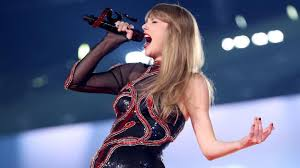